In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, PrecisionRecallDisplay
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksandralimkin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
data = pd.read_csv("labeled.csv", sep=",")

In [14]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


Приведем таргет к инту

In [18]:
data["toxic"] = data["toxic"].apply(int)

Разделим выборку на тестовую и тренировочную

In [19]:
train_df, test_df = train_test_split(data, test_size=500)

Пример токенизации

In [23]:
sentence_example = data.iloc[700]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [24]:
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Ты похож на въебливого зануду. А, не, не похож - он и есть. Фу таким быть. Особенно, если сам ничего не можешь, кроме как говном в интернете кидаться. , нет ли тут нарушений правил VovkaBright

-----------------
Токены: ['Ты', 'похож', 'на', 'въебливого', 'зануду', '.', 'А', ',', 'не', ',', 'не', 'похож', '-', 'он', 'и', 'есть', '.', 'Фу', 'таким', 'быть', '.', 'Особенно', ',', 'если', 'сам', 'ничего', 'не', 'можешь', ',', 'кроме', 'как', 'говном', 'в', 'интернете', 'кидаться', '.', ',', 'нет', 'ли', 'тут', 'нарушений', 'правил', 'VovkaBright']
-----------------
Токены без пунктуации: ['Ты', 'похож', 'на', 'въебливого', 'зануду', 'А', 'не', 'не', 'похож', 'он', 'и', 'есть', 'Фу', 'таким', 'быть', 'Особенно', 'если', 'сам', 'ничего', 'не', 'можешь', 'кроме', 'как', 'говном', 'в', 'интернете', 'кидаться', 'нет', 'ли', 'тут', 'нарушений', 'правил', 'VovkaBright']
-----------------
Токены без пунктуации и стоп слов: ['Ты', 'похож', 'въебливого', 'зануду', 'А', 'похож', 'Фу'

In [26]:
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [27]:
tokenize_sentence(sentence_example)

['ты',
 'похож',
 'въеблив',
 'зануд',
 'а',
 'похож',
 'фу',
 'так',
 'особен',
 'можеш',
 'кром',
 'говн',
 'интернет',
 'кида',
 'нарушен',
 'прав',
 'VovkaBright']

In [28]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

Получим tf-idf матрицу

In [32]:
features = vectorizer.fit_transform(train_df["comment"])

/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=42))
]
)

In [37]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x17413f5b0>)),
                ('model', LogisticRegression(random_state=42))])

In [39]:
model_pipeline.predict(["Чехол огонь!"])

array([0])

In [43]:
model_pipeline.predict(["Иди в жопу"])

array([1])

In [48]:
print(classification_report(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment'])))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       328
           1       0.89      0.54      0.67       172

    accuracy                           0.82       500
   macro avg       0.85      0.75      0.77       500
weighted avg       0.83      0.82      0.81       500



Пока что маленькие метрики, сделаем precision хоты бы не меньше 0.95, чтобы банить лишь 5% хороших комментариев

In [50]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])


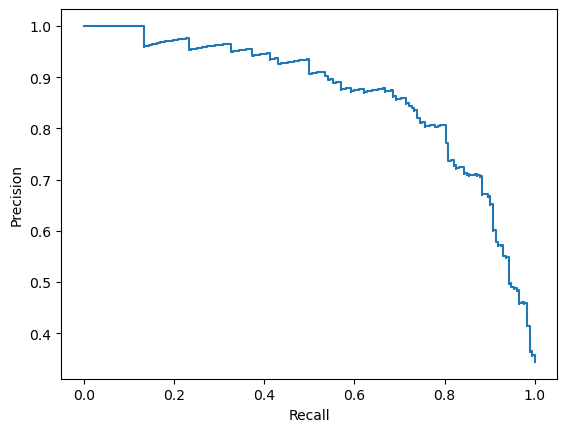

In [54]:
disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()

In [55]:
np.where(prec > 0.95)

(array([432, 433, 434, 435, 436, 437, 438, 441, 442, 443, 444, 445, 446,
        447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
        460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
        473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485,
        486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
        499]),)

In [56]:
thresholds[432]

0.6281332390471981

In [58]:
print(classification_report(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[432]))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85       328
           1       0.95      0.37      0.53       172

    accuracy                           0.78       500
   macro avg       0.85      0.68      0.69       500
weighted avg       0.82      0.78      0.74       500



Вот, уже лучше, но хотелось бы увеличить recall. Подберем коэффициент регуляризации по сетке

In [59]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=42),
        param_grid={'C': [0.1, 0.5, 1, 5., 10., ]},
        cv=3,
         verbose=4
        )
    )
])


In [60]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])

/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .............................C=0.1;, score=0.690 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.684 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.685 total time=   0.1s
[CV 1/3] END .............................C=0.5;, score=0.801 total time=   0.2s
[CV 2/3] END .............................C=0.5;, score=0.803 total time=   0.2s
[CV 3/3] END .............................C=0.5;, score=0.801 total time=   0.2s
[CV 1/3] END ...............................C=1;, score=0.839 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.835 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.836 total time=   0.2s
[CV 1/3] END .............................C=5.0;, score=0.866 total time=   0.5s


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .............................C=5.0;, score=0.863 total time=   0.5s


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END .............................C=5.0;, score=0.867 total time=   0.4s


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.868 total time=   0.4s


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.865 total time=   0.5s


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.867 total time=   0.5s


/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x176941090>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=42),
                              param_grid={'C': [0.1, 0.5, 1, 5.0, 10.0]},
                              verbose=4))])

In [61]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)

In [62]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x176c4a830>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [63]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])


In [64]:
np.where(prec_c_10 > 0.95)

(array([424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
        437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
        450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
        463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
        476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
        489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]),)

In [65]:
print(classification_report(y_true=test_df['toxic'], y_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c_10[424]))



              precision    recall  f1-score   support

           0       0.76      0.99      0.86       328
           1       0.96      0.41      0.58       172

    accuracy                           0.79       500
   macro avg       0.86      0.70      0.72       500
weighted avg       0.83      0.79      0.76       500



Итого получили recall 0.41 и precision 0.96 с коэффициентом регуляризации 10